# Quantum NLP with the lambeq–PennyLane integration

**References**

1. [PennyLane Blog | Quantum NLP with the lambeq–PennyLane integration](https://pennylane.ai/blog/2023/04/quantum-nlp-with-the-lambeq-pennylane-integration/)

## Preparing the hybrid QNLP model

In [1]:
import torch
import random
import numpy as np

# set seed for reproducibility
SEED = 12
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Inputting data

In [2]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            line = line.split(",")
            labels.append(int(line[2]))
            sentences.append((line[0], line[1]))
    return labels, sentences

train_labels, train_data = read_data("./data/mc_pair_train_data.csv")
dev_labels, dev_data = read_data("./data/mc_pair_dev_data.csv")
test_labels, test_data = read_data("./data/mc_pair_test_data.csv")

print(list(zip(train_data[:5], train_labels[:5])))

[(('person runs program .', 'skillful person cooks meal .'), 0), (('skillful man bakes dinner .', 'woman runs program .'), 0), (('man bakes tasty dinner .', 'person cooks meal .'), 1), (('woman runs application .', 'skillful man prepares program .'), 1), (('man bakes tasty meal .', 'man runs software .'), 0)]


## Creating and parameterizing diagrams

In [3]:
train_data_l, train_data_r = zip(*train_data)
train_data_unpaired = list(train_data_l) + list(train_data_r)
dev_data_l, dev_data_r = zip(*dev_data)
dev_data_unpaired = list(dev_data_l) + list(dev_data_r)
test_data_l, test_data_r = zip(*test_data)
test_data_unpaired = list(test_data_l) + list(test_data_r)
from lambeq import BobcatParser

reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data_unpaired)
raw_dev_diagrams = reader.sentences2diagrams(dev_data_unpaired)
raw_test_diagrams = reader.sentences2diagrams(test_data_unpaired)

/Users/ethan.chen/miniconda3/envs/quantum-lab/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


## Simplifying diagrams

❓ Bell effect postselection in a quantum circuit

In [4]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

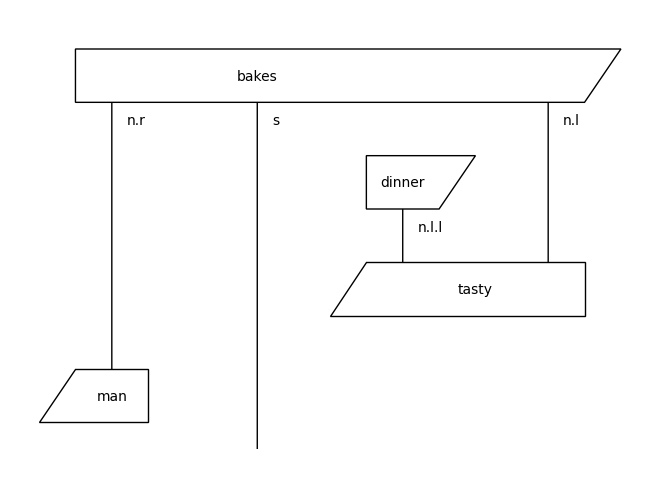

In [5]:
train_diagrams[2].draw()

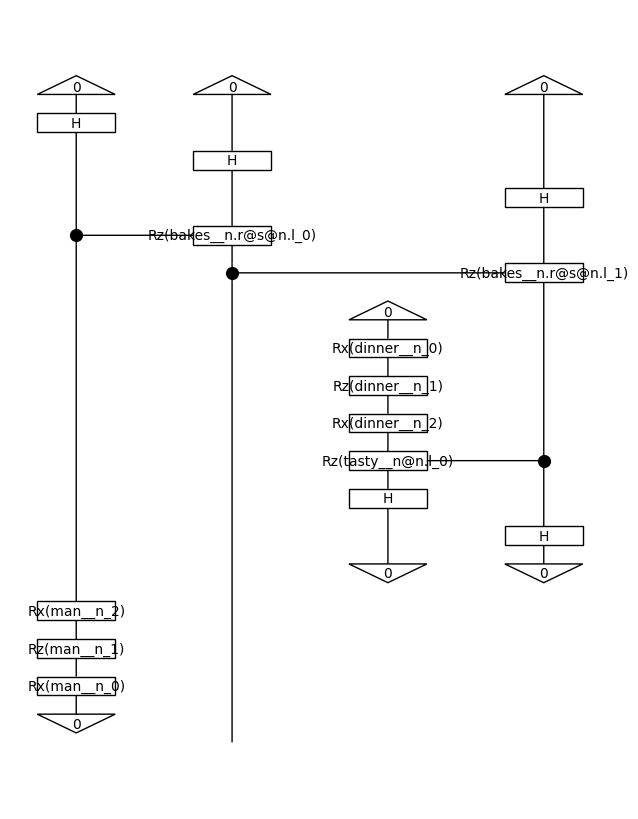

In [6]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz(
    {
        AtomicType.NOUN: 1,
        AtomicType.SENTENCE: 1,
    },
    n_layers=1,
    n_single_qubit_params=3,
)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[2].draw(figsize=(6, 8))

## Hybrid QNLP

In [7]:
BATCH_SIZE = 50
EPOCHS = 100
SEED = 2

In [8]:
from torch import nn
from lambeq import PennyLaneModel

# inherit from PennyLaneModel to use the PennyLane circuit evaluation
class XORSentenceModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)

        self.xor_net = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid(),
        )

    def forward(self, diagram_pairs):
        first_d, second_d = zip(*diagram_pairs)
        # evaluate each circuit and concatenate the results
        evaluated_pairs = torch.cat(
            (
                self.get_diagram_output(first_d),
                self.get_diagram_output(second_d),
            ),
            dim=1,
        )
        evaluated_pairs = 2 * (evaluated_pairs - 0.5)
        # pass the concatenated results through a simple neural network
        return self.xor_net(evaluated_pairs)

In [9]:
def make_pair_data(diagrams):
    pair_diags = list(zip(diagrams[:len(diagrams)//2], diagrams[len(diagrams)//2:]))
    return pair_diags

train_pair_circuits = make_pair_data(train_circuits)
dev_pair_circuits = make_pair_data(dev_circuits)
test_pair_circuits = make_pair_data(test_circuits)

In [14]:
from lambeq import Dataset

all_pair_circuits = (train_pair_circuits +
                     dev_pair_circuits +
                     test_pair_circuits)
a, b = zip(*all_pair_circuits)

# initialise our model by passing in the diagrams, so that we have trainable parameters for each token
model = XORSentenceModel.from_diagrams(a + b, probabilities=True, normalize=True)
model.initialise_weights()
model = model.double()

# initialise datasets and optimizers as in PyTorch
train_pair_dataset = Dataset(train_pair_circuits,
                             train_labels,
                             batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [15]:
def accuracy(circs, labels):
    predicted = model(circs)
    return (torch.round(torch.flatten(predicted)) ==
            torch.DoubleTensor(labels)).sum().item()/len(circs)
best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_pair_dataset:
        optimizer.zero_grad()
        predicted = model(circuits)
        # use BCELoss as our outputs are probabilities, and labels are binary
        loss = torch.nn.functional.binary_cross_entropy(
            torch.flatten(predicted), torch.DoubleTensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    # evaluate on dev set every 5 epochs
    # save the model if it's the best so far
    # stop training if the model hasn't improved for 10 epochs
    if i % 5 == 0:
        dev_acc = accuracy(dev_pair_circuits, dev_labels)

        print('Epoch: {}'.format(i))
        print('Train loss: {}'.format(epoch_loss))
        print('Dev acc: {}'.format(dev_acc))

        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.save('xor_model.lt')
        elif i - best['epoch'] >= 100:
            print('Early stopping')
            break

# load the best performing iteration of the model on the dev set
if best['acc'] > accuracy(dev_pair_circuits, dev_labels):
    model.load('xor_model.lt')
    model = model.double()

Epoch: 0
Train loss: 4.303399115267592
Dev acc: 0.56
Epoch: 5
Train loss: 1.4554321100261118
Dev acc: 0.6
Epoch: 10
Train loss: 2.3362614552679966
Dev acc: 1.0
Epoch: 15
Train loss: 0.3852107695856396
Dev acc: 0.95
Epoch: 20
Train loss: 0.09845486562814251
Dev acc: 0.94
Epoch: 25
Train loss: 0.054681329228288986
Dev acc: 0.935
Epoch: 30
Train loss: 0.03777087286057578
Dev acc: 0.935
Epoch: 35
Train loss: 0.028556693743167876
Dev acc: 0.935
Epoch: 40
Train loss: 0.022640694036758457
Dev acc: 0.935
Epoch: 45
Train loss: 0.018573088159831865
Dev acc: 0.935
Epoch: 50
Train loss: 0.01558199279893802
Dev acc: 0.935
Epoch: 55
Train loss: 0.013326697933631332
Dev acc: 0.935
Epoch: 60
Train loss: 0.011576039802788402
Dev acc: 0.935
Epoch: 65
Train loss: 0.010160172178612504
Dev acc: 0.935
Epoch: 70
Train loss: 0.009016782745896006
Dev acc: 0.935
Epoch: 75
Train loss: 0.008064855809469498
Dev acc: 0.935
Epoch: 80
Train loss: 0.0072645391884419465
Dev acc: 0.935
Epoch: 85
Train loss: 0.0065791980

In [16]:
print('Final test accuracy: {}'.format(accuracy(test_pair_circuits,
                                                test_labels)))

Final test accuracy: 0.95
